In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-deepfakes-lung-cancer/Response EXP2 - Reviewer 3_instances.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP2 - Reviewer 2_patients.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP1 - Reviewer 3_instances.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP1 - Reviewer 2_instances.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP1 - Reviewer 3_patients.csv
/kaggle/input/medical-deepfakes-lung-cancer/labels_exp2.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP2 - Reviewer 2_instances.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP2 - Reviewer 1_patients.csv
/kaggle/input/medical-deepfakes-lung-cancer/labels_exp1.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP1 - Reviewer 1_instances.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP2 - Reviewer 1_instances.csv
/kaggle/input/medical-deepfakes-lung-cancer/Response EXP1 - Reviewer 2_patients.csv
/kaggle/input/medical-deepfakes-lu

In [2]:
import os
import pydicom
import cv2
import numpy as np
from tqdm import tqdm


# Input and output directories
dcm_root_dir = "/kaggle/input/medical-deepfakes-lung-cancer/CT_Scans"  # Update with actual path
jpg_root_dir = "/kaggle/working/dataset_jpg"  # Output directory for JPEG images

# Function to convert DICOM to JPG
def convert_dcm_to_jpg(dcm_root, jpg_root):
    for exp_dir in ["EXP1_blind", "EXP2_open"]:  # Loop through both experiment directories
        dcm_exp_path = os.path.join(dcm_root, exp_dir)
        jpg_exp_path = os.path.join(jpg_root, exp_dir)
        os.makedirs(jpg_exp_path, exist_ok=True)
        
        # Traverse all patient directories
        for patient_folder in os.listdir(dcm_exp_path):
            patient_dcm_path = os.path.join(dcm_exp_path, patient_folder)
            patient_jpg_path = os.path.join(jpg_exp_path, patient_folder)
            os.makedirs(patient_jpg_path, exist_ok=True)

            for file in tqdm(os.listdir(patient_dcm_path), desc=f"Converting {exp_dir}/{patient_folder}"):
                if file.endswith(".dcm"):
                    dcm_file = os.path.join(patient_dcm_path, file)
                    jpg_file = os.path.join(patient_jpg_path, file.replace(".dcm", ".jpg"))

                    try:
                        # Read DICOM file
                        dicom_data = pydicom.dcmread(dcm_file)
                        image = dicom_data.pixel_array  # Extract pixel data
                        
                        # Normalize and convert to 8-bit grayscale
                        image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
                        image = image.astype(np.uint8)
                        
                        # Save as JPEG
                        cv2.imwrite(jpg_file, image)

                    except Exception as e:
                        print(f"Error converting {dcm_file}: {e}")

# Run the conversion
convert_dcm_to_jpg(dcm_root_dir, jpg_root_dir)

print("DICOM to JPEG conversion complete!")

Converting EXP1_blind/3025:  21%|██        | 48/233 [00:00<00:02, 68.53it/s]/tmp/ipykernel_31/3554136992.py:36: RuntimeWarning: overflow encountered in scalar subtract
  image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
Converting EXP2_open/2366: 100%|██████████| 133/133 [00:02<00:00, 63.69it/s]

DICOM to JPEG conversion complete!


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Base dataset directory
dataset_path = '/kaggle/working/dataset_jpg'

# Output directories
output_dir = '/kaggle/working/split_dataset'
train_dir = os.path.join(output_dir, 'train')
valid_dir = os.path.join(output_dir, 'valid')
test_dir = os.path.join(output_dir, 'test')

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Train, Test, Validation split ratios
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# Iterate over main classes (EXP1_blind, EXP2_open)
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    
    if os.path.isdir(class_path):
        # Iterate over subdirectories (e.g., 1067, 1068, ...)
        for sub_folder in os.listdir(class_path):
            sub_folder_path = os.path.join(class_path, sub_folder)
            
            if os.path.isdir(sub_folder_path):
                images = os.listdir(sub_folder_path)
                
                # Train-Test-Validation split
                train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
                valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (test_ratio + valid_ratio), random_state=42)
                
                # Copy images to respective directories
                for img in train_imgs:
                    src = os.path.join(sub_folder_path, img)
                    dst = os.path.join(train_dir, class_folder, sub_folder)
                    os.makedirs(dst, exist_ok=True)
                    shutil.copy(src, dst)
                
                for img in valid_imgs:
                    src = os.path.join(sub_folder_path, img)
                    dst = os.path.join(valid_dir, class_folder, sub_folder)
                    os.makedirs(dst, exist_ok=True)
                    shutil.copy(src, dst)
                
                for img in test_imgs:
                    src = os.path.join(sub_folder_path, img)
                    dst = os.path.join(test_dir, class_folder, sub_folder)
                    os.makedirs(dst, exist_ok=True)
                    shutil.copy(src, dst)

print("Dataset successfully split into train, validation, and test sets.")

Dataset successfully split into train, validation, and test sets.


**CNN model**

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Paths to the converted dataset
dataset_dir = "/kaggle/working/split_dataset"  # Update this path
train_dir = os.path.join(dataset_dir, "train")  # Organize dataset into train/test
test_dir = os.path.join(dataset_dir, "test")

# Image Parameters
IMG_SIZE = 224  # Image resolution
BATCH_SIZE = 32

# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.2  # Split 80% train, 20% validation
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: Real vs Fake
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10)

# Test the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save("deepfake_detection_model.h5")

2025-05-15 12:49:04.667098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747313344.690290     260 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747313344.700945     260 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 12696 images belonging to 2 classes.
Found 3174 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747313347.791568     260 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747313347.792226     260 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747313354.339949     329 service.cc:148] XLA service 0x79e3f40069b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747313354.339987     329 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747313354.339991     329 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747313354.574650     329 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/397 ━━━━━━━━━━━━━━━━━━━━ 1:03:24 10s/step - accuracy: 0.5938 - loss: 0.6837

I0000 00:00:1747313358.884727     329 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


397/397 ━━━━━━━━━━━━━━━━━━━━ 183s 438ms/step - accuracy: 0.7612 - loss: 0.5618 - val_accuracy: 0.7502 - val_loss: 0.5456
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 173s 429ms/step - accuracy: 0.7793 - loss: 0.5175 - val_accuracy: 0.7558 - val_loss: 0.5224
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 171s 425ms/step - accuracy: 0.7907 - loss: 0.4826 - val_accuracy: 0.7640 - val_loss: 0.5137
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 172s 426ms/step - accuracy: 0.8073 - loss: 0.4554 - val_accuracy: 0.7637 - val_loss: 0.5632
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 172s 428ms/step - accuracy: 0.8259 - loss: 0.4232 - val_accuracy: 0.7669 - val_loss: 0.5341
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 172s 426ms/step - accuracy: 0.8322 - loss: 0.4135 - val_accuracy: 0.7750 - val_loss: 0.5442
Epoch 7/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 172s 428ms/step - accuracy: 0.8352 - loss: 0.3992 - val_accuracy: 0.7845 - val_loss: 0.5352
Epoch 8/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 172s 427ms/step - accuracy: 0.8411 - loss: 0.38

In [5]:
# Image preprocessing and augmentation
IMG_SIZE = 224  # Resize images
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 12696 images belonging to 2 classes.
Found 3174 images belonging to 2 classes.


In [6]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Paths
model_path = 'deepfake_detection_model.h5'  # Path to your trained model
test_dir = '/kaggle/working/split_dataset/test'  # Path to the test dataset

# Load the model
model = load_model(model_path)

# Image preprocessing parameters
img_size = (224, 224)  # Change this to the input size of your model

# Class labels (Update based on your dataset)
class_labels = ['EXP1_blind', 'EXP2_open']

# Perform inference
def predict_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Perform prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class]

    return class_labels[predicted_class], confidence

# Iterate over test images and make predictions
results = []
for class_folder in os.listdir(test_dir):
    class_folder_path = os.path.join(test_dir, class_folder)
    if os.path.isdir(class_folder_path):
        for sub_folder in os.listdir(class_folder_path):
            sub_folder_path = os.path.join(class_folder_path, sub_folder)
            if os.path.isdir(sub_folder_path):
                for img_file in os.listdir(sub_folder_path):
                    img_path = os.path.join(sub_folder_path, img_file)
                    predicted_class, confidence = predict_image(img_path)
                    results.append({
                        "image": img_file,
                        "actual_class": class_folder,
                        "predicted_class": predicted_class,
                        "confidence": confidence
                    })

# Display results
for result in results:
    print(f"Image: {result['image']}, Actual: {result['actual_class']}, "
          f"Predicted: {result['predicted_class']}, Confidence: {result['confidence']:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

Found 3465 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.8515 - loss: 0.4092
Test Loss: 0.41728389263153076
Test Accuracy: 0.8507936596870422
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step


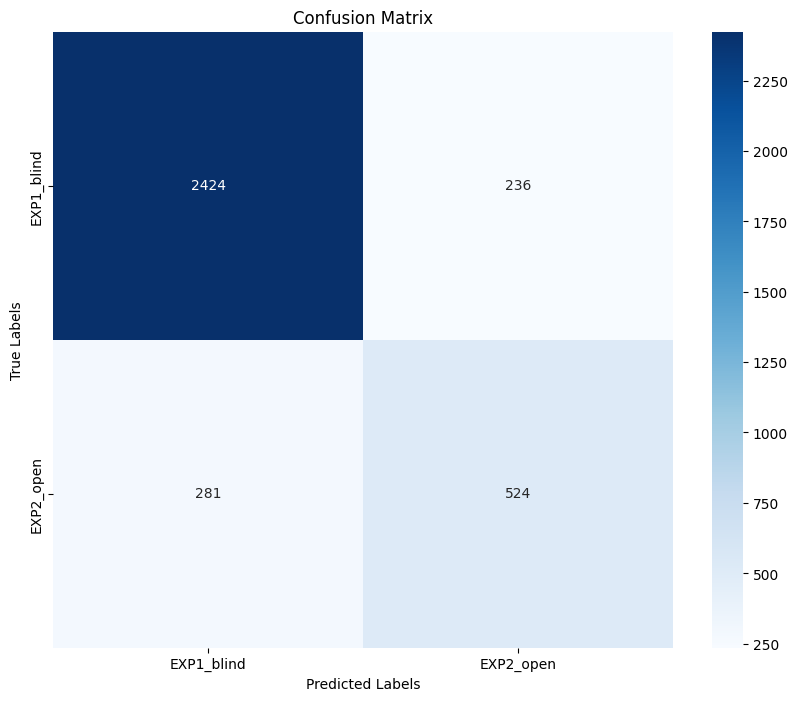


Classification Report:

              precision    recall  f1-score   support

  EXP1_blind       0.90      0.91      0.90      2660
   EXP2_open       0.69      0.65      0.67       805

    accuracy                           0.85      3465
   macro avg       0.79      0.78      0.79      3465
weighted avg       0.85      0.85      0.85      3465



In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('deepfake_detection_model.h5')

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Prepare the test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/split_dataset/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # For binary classification
    shuffle=False
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict classes
test_generator.reset()
predictions = (model.predict(test_generator, verbose=1) > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(test_generator.classes, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
report = classification_report(test_generator.classes, predictions,
                               target_names=test_generator.class_indices.keys())
print("\nClassification Report:\n")
print(report)

**Combining CNN and ViT**

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from tqdm import tqdm
import timm

# Paths to the converted dataset
dataset_dir = "/kaggle/working/split_dataset"  # update as needed
train_dir   = os.path.join(dataset_dir, "train")
test_dir    = os.path.join(dataset_dir, "test")

# Image parameters
IMG_SIZE   = 224
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 5    # first train CNN
NUM_EPOCHS_HYBRID = 5 # then fine-tune hybrid ViT
LR_CNN     = 1e-4
LR_HYBRID  = 1e-4

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# Datasets & Loaders
full_train = datasets.ImageFolder(train_dir, transform=train_transform)
train_size = int(0.8 * len(full_train))
val_size   = len(full_train) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_train, [train_size, val_size])
val_ds.dataset.transform = val_transform
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_ds = datasets.ImageFolder(test_dir, transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 1. Define and train the CNN
class DeepfakeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        flat_size = 128 * (IMG_SIZE//8) * (IMG_SIZE//8)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

cnn_model = DeepfakeCNN().to(device)
criterion_cnn = nn.BCEWithLogitsLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LR_CNN)

for epoch in range(1, NUM_EPOCHS_CNN+1):
    cnn_model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f"CNN Epoch {epoch}/{NUM_EPOCHS_CNN}"):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float().to(device)
        optimizer_cnn.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion_cnn(outputs, labels)
        loss.backward(); optimizer_cnn.step()
        total_loss += loss.item() * inputs.size(0)
    print(f"CNN Epoch {epoch} Loss: {total_loss/len(train_ds):.4f}")
# Save CNN weights for backbone
cnn_weights = cnn_model.state_dict()

# 2. Create Hybrid ViT with ResNet50 backbone
hybrid = timm.create_model('vit_base_r50_s16_224', pretrained=True, num_classes=1)
hybrid.to(device)

# 3. Transfer CNN-features to hybrid's patch_embed.backbone
hybrid_state = hybrid.state_dict()
for k, v in cnn_weights.items():
    hybrid_k = f'patch_embed.backbone.{k}'
    if hybrid_k in hybrid_state and hybrid_state[hybrid_k].shape == v.shape:
        hybrid_state[hybrid_k] = v
hybrid.load_state_dict(hybrid_state)

# 4. Fine-tune hybrid ViT
criterion_hyb = nn.BCEWithLogitsLoss()
optimizer_hyb = optim.Adam(hybrid.parameters(), lr=LR_HYBRID)
for epoch in range(1, NUM_EPOCHS_HYBRID+1):
    hybrid.train()
    loss_sum = 0
    for inputs, labels in tqdm(train_loader, desc=f"Hybrid Epoch {epoch}/{NUM_EPOCHS_HYBRID}"):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float().to(device)
        optimizer_hyb.zero_grad()
        outputs = hybrid(inputs)
        loss = criterion_hyb(outputs, labels)
        loss.backward(); optimizer_hyb.step()
        loss_sum += loss.item() * inputs.size(0)
    print(f"Hybrid Epoch {epoch} Train Loss: {loss_sum/len(train_ds):.4f}")

# 5. Evaluate on Test Set
hybrid.eval()
correct = 0; total = 0
test_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float().to(device)
        outputs = hybrid(inputs)
        test_loss += criterion_hyb(outputs, labels).item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item(); total += labels.size(0)
print(f"Test Loss: {test_loss/len(test_ds):.4f} | Test Acc: {correct/total:.4f}")

# Save hybrid model
torch.save(hybrid.state_dict(), "/kaggle/working/hybrid_deepfake_vit.pth")
print("Hybrid model saved.")


Using device: cuda


CNN Epoch 1/5: 100%|██████████| 397/397 [00:33<00:00, 11.69it/s]


CNN Epoch 1 Loss: 0.3729


CNN Epoch 2/5: 100%|██████████| 397/397 [00:33<00:00, 11.93it/s]


CNN Epoch 2 Loss: 0.1478


CNN Epoch 3/5: 100%|██████████| 397/397 [00:32<00:00, 12.07it/s]


CNN Epoch 3 Loss: 0.0787


CNN Epoch 4/5: 100%|██████████| 397/397 [00:32<00:00, 12.07it/s]


CNN Epoch 4 Loss: 0.0585


CNN Epoch 5/5: 100%|██████████| 397/397 [00:33<00:00, 11.85it/s]


CNN Epoch 5 Loss: 0.0501


model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

Hybrid Epoch 1/5: 100%|██████████| 397/397 [09:16<00:00,  1.40s/it]


Hybrid Epoch 1 Train Loss: 0.3001


Hybrid Epoch 2/5: 100%|██████████| 397/397 [09:16<00:00,  1.40s/it]


Hybrid Epoch 2 Train Loss: 0.0732


Hybrid Epoch 3/5: 100%|██████████| 397/397 [09:16<00:00,  1.40s/it]


Hybrid Epoch 3 Train Loss: 0.0583


Hybrid Epoch 4/5: 100%|██████████| 397/397 [09:16<00:00,  1.40s/it]


Hybrid Epoch 4 Train Loss: 0.0341


Hybrid Epoch 5/5: 100%|██████████| 397/397 [09:16<00:00,  1.40s/it]

Hybrid Epoch 5 Train Loss: 0.0341


Test Loss: 0.0345 | Test Acc: 0.9760
Hybrid model saved.


**Metrics**

Using device: cuda


/tmp/ipykernel_260/3685675859.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/hybrid_deepfake_vit.pth", map_location=device)


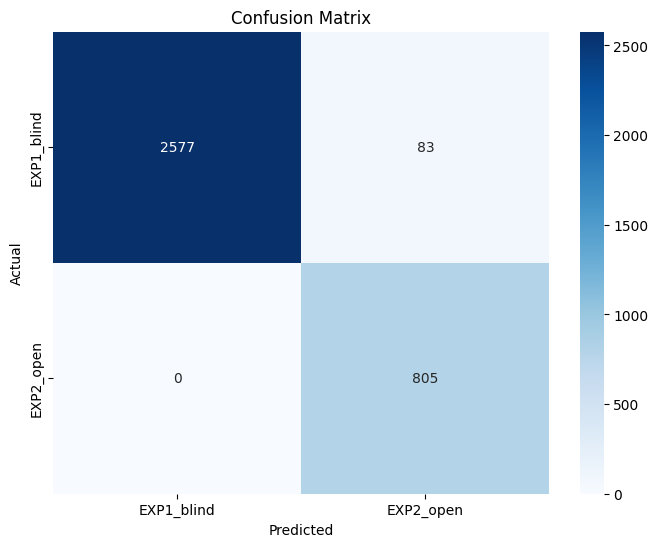

Classification Report:


Test Accuracy: 0.9760

              precision    recall  f1-score   support

  EXP1_blind       1.00      0.97      0.98      2660
   EXP2_open       0.91      1.00      0.95       805

    accuracy                           0.98      3465
   macro avg       0.95      0.98      0.97      3465
weighted avg       0.98      0.98      0.98      3465



In [9]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import timm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Build the hybrid ViT‑ResNet50 model with a binary head
model = timm.create_model('vit_base_r50_s16_224', pretrained=False, num_classes=1)
model.to(device)

# 2. Load your fine‑tuned hybrid weights
checkpoint = torch.load("/kaggle/working/hybrid_deepfake_vit.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# 3. Data setup
IMG_SIZE   = 224
BATCH_SIZE = 32
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

test_dataset = datasets.ImageFolder(
    "/kaggle/working/split_dataset/test",
    transform=test_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

# 4. Run inference
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        logits = model(inputs)
        probs  = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        preds  = (probs > 0.5).astype(int)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())

# 5. Metrics


# 6. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 7. Classification report
print("Classification Report:\n")
acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy: {acc:.4f}\n")
print(classification_report(all_labels, all_preds,
                            target_names=test_dataset.classes))


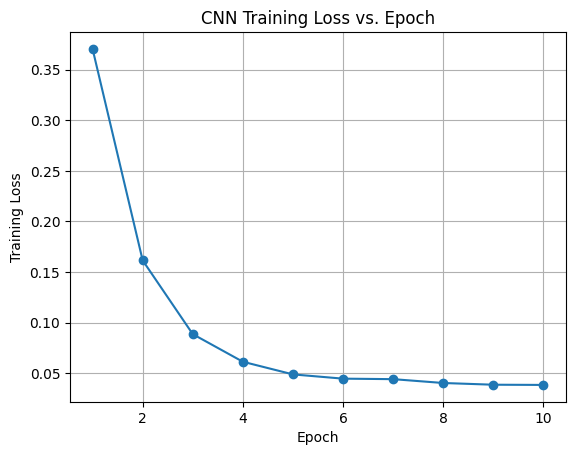

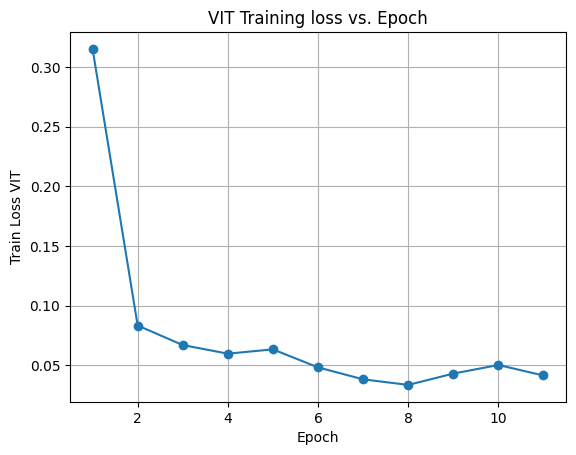

In [10]:
import numpy as np
import matplotlib.pyplot as plt
# 1. Plot training loss & validation accuracy
train_losses_cnn = [
    0.3705,
    0.1614,
    0.0885,
    0.0612,
    0.0487,
    0.0445,
    0.0440,
    0.0402,
    0.0385,
    0.0383    
]   # replace with your data
train_loss_vit = [0.3151,
    0.0833,
    0.0669,
    0.0597,
    0.0633,
    0.0482,
    0.0382,
    0.0335,
    0.0430,
    0.0502,
    0.0414]     # replace with your data

plt.figure()
plt.plot(range(1, len(train_losses_cnn)+1), train_losses_cnn, marker='o')
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("CNN Training Loss vs. Epoch"); plt.grid(True); plt.show()

plt.figure()
plt.plot(range(1, len(train_loss_vit)+1), train_loss_vit, marker='o')
plt.xlabel("Epoch"); plt.ylabel("Train Loss VIT")
plt.title("VIT Training loss vs. Epoch"); plt.grid(True); plt.show()


**Explainability**

/tmp/ipykernel_31/1193609904.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/working/hybrid_deepfake_vit.pth", map_location=device)


Predicted label: 0


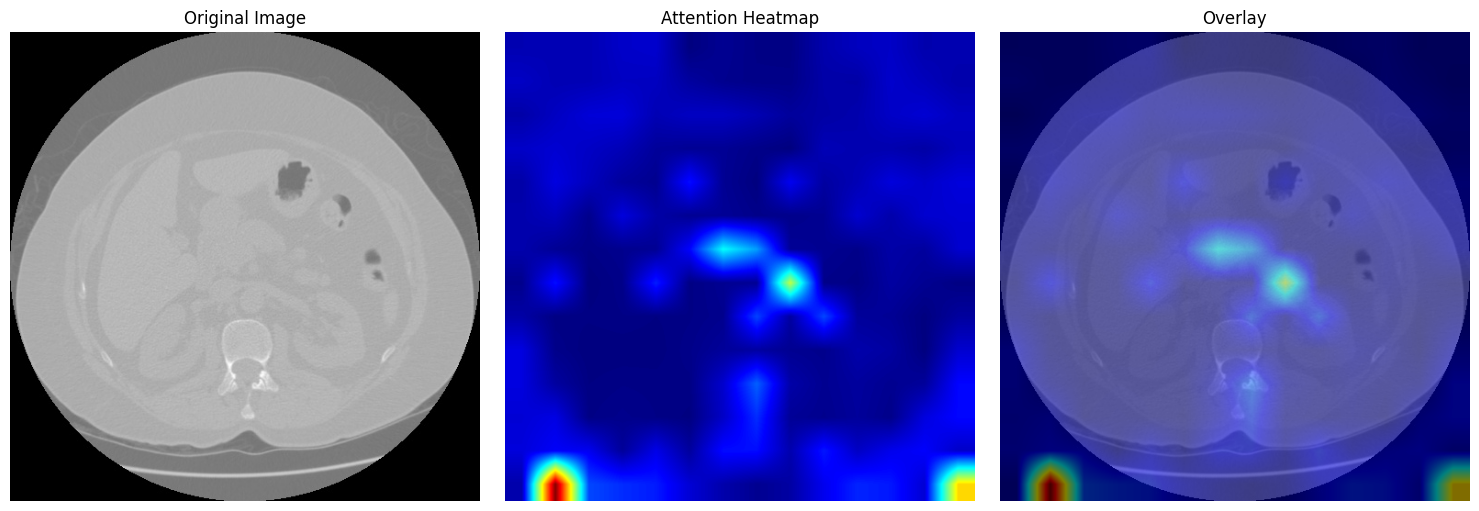

In [5]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import timm
from torchvision import transforms

# 1. Rollout helper (fixed head‐averaging dim)
def compute_rollout_attention(attn_maps):
    result = torch.eye(attn_maps[0].size(-1), device=attn_maps[0].device)
    for a in attn_maps:
        # a: (heads, seq_len, seq_len) → fuse heads
        a_fused = a.mean(dim=0)  # now (seq_len, seq_len)
        # add identity (residual) and renormalize
        a_fused = a_fused + torch.eye(a_fused.size(-1), device=a_fused.device)
        a_fused = a_fused / a_fused.sum(-1, keepdim=True)
        result = result @ a_fused
    return result

# 2. Load hybrid ViT‐ResNet50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_base_r50_s16_224', pretrained=False, num_classes=1)
ckpt = torch.load("/kaggle/working/hybrid_deepfake_vit.pth", map_location=device)
model.load_state_dict(ckpt)
model.to(device).eval()

# 3. Monkey‐patch each block.attn to capture raw attention
attn_maps = []
for block in model.blocks:
    m = block.attn  # timm Attention module
    def make_forward(orig_forward, m):
        def new_forward(x):
            B, N, C = x.shape
            # compute QKV
            qkv = m.qkv(x).reshape(B, N, 3, m.num_heads, C//m.num_heads)
            qkv = qkv.permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]  # each (B, heads, N, head_dim)
            # raw attention
            attn = (q @ k.transpose(-2, -1)) * m.scale
            attn = attn.softmax(dim=-1)
            attn_maps.append(attn.detach()[0])  # store for batch item 0
            # continue original forward
            attn_drop = m.attn_drop(attn)
            x2 = (attn_drop @ v).transpose(1, 2).reshape(B, N, C)
            x2 = m.proj(x2)
            x2 = m.proj_drop(x2)
            return x2
        return new_forward
    m.forward = make_forward(m.forward, m)

# 4. Preprocess single image
IMG_SIZE = 224
path = "/kaggle/working/dataset_jpg/EXP1_blind/1003/0.jpg"
img = Image.open(path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
inp = transform(img).unsqueeze(0).to(device)

# 5. Forward pass to populate attn_maps
with torch.no_grad():
    # patch embedding + cls token + pos embed + dropout
    x = model.patch_embed(inp)
    cls_tok = model.cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_tok, x), dim=1)
    x = x + model.pos_embed
    x = model.pos_drop(x)
    # transformer blocks (our patched forwards fill attn_maps)
    for blk in model.blocks:
        x = blk(x)
    # final norm + classification head
    x = model.norm(x)
    logits = model.head(x[:, 0])
    pred = (torch.sigmoid(logits) > 0.5).long().item()

print("Predicted label:", pred)

# 6. Compute rollout
rollout = compute_rollout_attention(attn_maps)
cls_to_patches = rollout[0, 1:]  # CLS→patches

# 7. Build heatmap + overlay
num = cls_to_patches.shape[0]  # e.g. 196
g   = int(np.sqrt(num))        # 14
attn_map = cls_to_patches.reshape(g, g).cpu().numpy()
attn_map = (attn_map - attn_map.min())/(attn_map.max() - attn_map.min())
attn_map = cv2.resize(attn_map, (img.width, img.height))
attn_map = np.uint8(255 * attn_map)
heatmap = cv2.applyColorMap(attn_map, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
orig = np.array(img)
overlay = cv2.addWeighted(orig, 0.5, heatmap, 0.5, 0)

# 8. Plot results
plt.figure(figsize=(15,5))
for i, (title, arr) in enumerate([
    ("Original Image", orig),
    ("Attention Heatmap", heatmap),
    ("Overlay", overlay),
]):
    plt.subplot(1, 3, i+1)
    plt.imshow(arr)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()
